In [220]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPClassifier
from undrafted_script import annual_undrafted

In [221]:
pd.set_option('display.max_rows', 100) 
draft_data = pd.read_csv('draft-data-20-years.csv')
all_seasons_data = pd.read_csv('all_seasons.csv')

draft_data = draft_data[['Player', 'Yrs', 'WS', 'WS/48','DraftYear']] #only keeping relevant columns

# Cleaning data
all_seasons_data.rename(columns={'player_name': 'Player', 'draft_year': 'DraftYear'}, inplace=True) 
all_seasons_data = all_seasons_data[all_seasons_data['DraftYear'] != 'Undrafted']
all_seasons_data['DraftYear'] = all_seasons_data['DraftYear'].astype(int)
all_seasons_data = all_seasons_data.drop_duplicates(subset='Player', keep='first')
all_seasons_data_sub = all_seasons_data[['Player', 'age', 'player_height', 'player_weight', 'draft_number', 'DraftYear']]

# Combining both datasets
df = pd.merge(draft_data, all_seasons_data_sub, on=['Player', 'DraftYear'],how='inner')
df['draft_number'] = df['draft_number'].astype('int64')
df=df.fillna(0)
df

,Player,Yrs,WS,WS/48,DraftYear,age,player_height,player_weight,draft_number
0,Derrick Coleman,15.0,64.3,0.119,1990,30.0,208.28,117.933920,1
1,Gary Payton,17.0,145.5,0.148,1990,28.0,193.04,86.182480,2
2,Mahmoud Abdul-Rauf,9.0,25.2,0.077,1990,28.0,185.42,73.481904,3
3,Dennis Scott,10.0,33.4,0.089,1990,28.0,203.20,106.594120,4
4,Kendall Gill,15.0,47.8,0.078,1990,29.0,195.58,97.975872,5
...,...,...,...,...,...,...,...,...,...
1417,Aaron Wiggins,1.0,1.2,0.077,2021,23.0,193.04,86.182480,55
1418,Scottie Lewis,1.0,0.0,0.164,2021,22.0,195.58,83.914520,56
1419,Jericho Sims,1.0,0.4,0.145,2021,23.0,205.74,113.398000,58
1420,RaiQuan Gray,0.0,0.0,0.000,2021,23.0,200.66,122.016248,59


In [222]:
# Selecting model inputs and training sample
model_inputs =['age', 'player_height', 'player_weight', 'draft_number']

train_sample = df.sample(frac=0.75, random_state=1)

x_train = train_sample
y_train = train_sample['WS']

In [223]:
# Selecting dev and test samples
not_train = df[~df.index.isin(train_sample.index)]

dev_sample = not_train.sample(frac=0.75, random_state=1)
x_dev = dev_sample
y_dev = dev_sample['WS']

not_dev = not_train[~not_train.index.isin(dev_sample.index)]
x_test = not_dev
y_test = not_dev['WS']

len(x_train), len(x_dev), len(x_test)

(1066, 267, 89)

In [224]:
#Basic Linear Model Creation
lin_model = LinearRegression(fit_intercept=True)

# Fit and Predict
lin_model.fit(x_train[model_inputs].to_numpy(), y_train)
lin_pred = lin_model.predict(x_dev[model_inputs])

# Adding predcition column
x_dev['lin_pred'] = lin_pred
x_dev

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Player,Yrs,WS,WS/48,DraftYear,age,player_height,player_weight,draft_number,lin_pred
1255,Zion Williamson,2.0,10.6,0.189,2019,19.0,198.12,128.820128,1,33.453345
666,Maurice Ager,4.0,-0.9,-0.089,2006,23.0,195.58,91.625584,28,17.627204
420,Jason Hart,9.0,8.6,0.078,2000,23.0,187.96,82.100152,49,1.129125
485,Juan Dixon,7.0,6.1,0.034,2002,24.0,190.50,74.389088,17,26.831489
469,Jarron Collins,10.0,15.7,0.088,2001,23.0,210.82,114.305184,52,0.591289
...,...,...,...,...,...,...,...,...,...,...
174,Randolph Childress,2.0,-0.2,-0.026,1995,24.0,187.96,85.275296,19,24.283163
1360,Cassius Winston,2.0,0.2,0.084,2020,23.0,185.42,83.914520,53,-2.397802
123,Brian Grant,12.0,54.5,0.122,1994,25.0,205.74,115.212368,8,34.337851
1337,Udoka Azubuike,2.0,0.7,0.141,2020,21.0,208.28,127.005760,27,16.928252


In [225]:
# Finding mean squared error
lin_reg_RMSE = np.sqrt(np.nanmean(np.square(lin_model.predict(x_train[model_inputs]) - x_train['WS'])))
lin_reg_RMSE

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


25.779898626305965

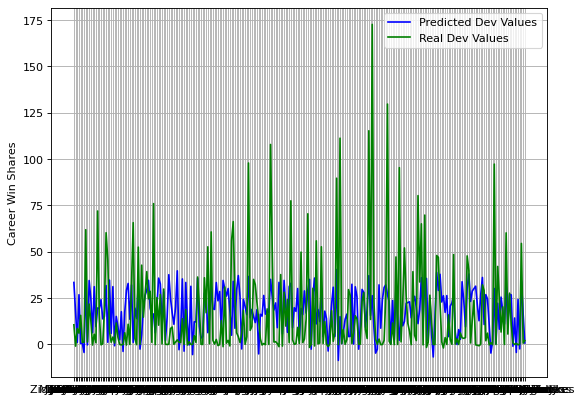

In [226]:
# Graphical representation
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

players = x_dev['Player'].tolist()

figure(figsize=(8, 6), dpi=80)
plt.plot(players, x_dev['lin_pred'].tolist(), 'b', label='Predicted Dev Values')
plt.plot(players, x_dev['WS'].tolist(), 'g', label='Real Dev Values')

plt.ylabel("Career Win Shares")
plt.grid(True)
plt.legend()


In [227]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [228]:
# Model Analysis
ridge = Ridge()

param_grid = {'alpha': [0.1, 0.5, 1, 10, 100, 200, 500, 5000, 10000]}

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train[model_inputs], y_train)

# Finding best estimator and best Ridge RMSE
best_ridge_model = grid_search.best_estimator_
ridge_rmse = np.sqrt(-grid_search.best_score_)
print("Best estimator:", best_ridge_model)
print("Best Ridge RMSE:", ridge_rmse)

Best estimator: Ridge(alpha=10000)
Best Ridge RMSE: 25.941282558122147


In [229]:
#Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
x_train_poly = poly.fit_transform(x_train[model_inputs])

grid_search.fit(x_train_poly, y_train)

# Noisy and relatively small dataset which likely explains lack of improvement in RMSE
print("Best Ridge RMSE:", ridge_rmse)
print("Best Parameters:", grid_search.best_params_)

Best Ridge RMSE: 25.941282558122147
Best Parameters: {'alpha': 100}


In [230]:
def normalize(df):
    df = df.copy()
    for col in df.columns:
        data = df[col]
        df[col] = (data - np.min(data)) / (np.max(data) - np.min(data))
    return df

In [231]:
x_input = normalize(x_train[model_inputs]).to_numpy()
y_input = y_train

from sklearn.neural_network import MLPRegressor

# Using MLP because of data format in table as a prediction problem
MLP_model = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu',
                         solver='adam', alpha=0.001, learning_rate_init=0.005, batch_size=64,
                         random_state=1, max_iter=500, early_stopping=True, validation_fraction=0.1,
                         n_iter_no_change=5, verbose=True)

MLP_model.fit(x_input, y_input)

MLP = MLPClassifier()


Iteration 1, loss = 587.74650684
Validation score: -0.536090
Iteration 2, loss = 565.68876409
Validation score: -0.464999
Iteration 3, loss = 540.79745624
Validation score: -0.377781
Iteration 4, loss = 507.56604477
Validation score: -0.256892
Iteration 5, loss = 465.78721108
Validation score: -0.132471
Iteration 6, loss = 438.39254433
Validation score: -0.062907
Iteration 7, loss = 422.35217865
Validation score: -0.042044
Iteration 8, loss = 415.36673316
Validation score: -0.026117
Iteration 9, loss = 409.26507112
Validation score: -0.012389
Iteration 10, loss = 403.52328778
Validation score: 0.001799
Iteration 11, loss = 397.57188978
Validation score: 0.014377
Iteration 12, loss = 391.84603026
Validation score: 0.027609
Iteration 13, loss = 386.21976170
Validation score: 0.040547
Iteration 14, loss = 380.75845927
Validation score: 0.053490
Iteration 15, loss = 374.82214630
Validation score: 0.064905
Iteration 16, loss = 369.63081142
Validation score: 0.075921
Iteration 17, loss = 364

In [232]:
train_predict = MLP_model.predict(normalize(x_train[model_inputs]).to_numpy())
RMSE_train_mlp = np.sqrt(np.nanmean(np.square(train_predict - y_train)))
#Brier_train_mlp = brier_score_loss(train_labels, train_predict[:,1])
#Logloss_train_mlp = log_loss(train_labels, train_predict[:,1])
print('RMSE_train_mlp: %0.4f' %(RMSE_train_mlp) )
#print('Brier_train_mlp: %0.4f' %(Brier_train_mlp) )
#print('Logloss_train_mlp: %0.4f' %(Logloss_train_mlp) )

RMSE_train_mlp: 25.4674


In [233]:
train_predict

array([28.38750102, 35.18546163, 17.9933937 , ..., 16.06099786,
       29.57349391, 22.99183115])